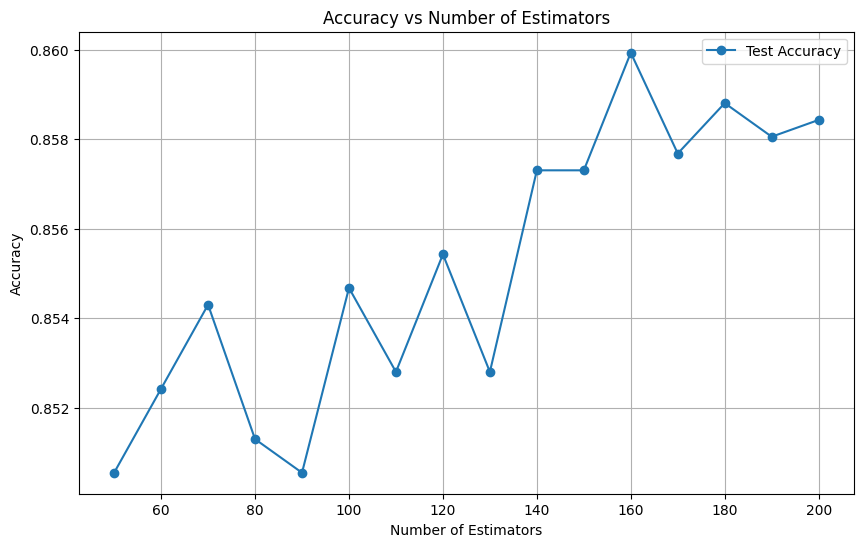

Best n_estimators: 160
Accuracy: 0.86
Confusion Matrix:
[[379   0   0   1   0   0   0]
 [  0 373   2   3   2   0   0]
 [  2  22 276  62  15   3   0]
 [  0   9  87 195  74  16   0]
 [  0   2   6  41 316  16   0]
 [  0   0   1   3   6 370   0]
 [  0   0   0   0   0   0 381]]


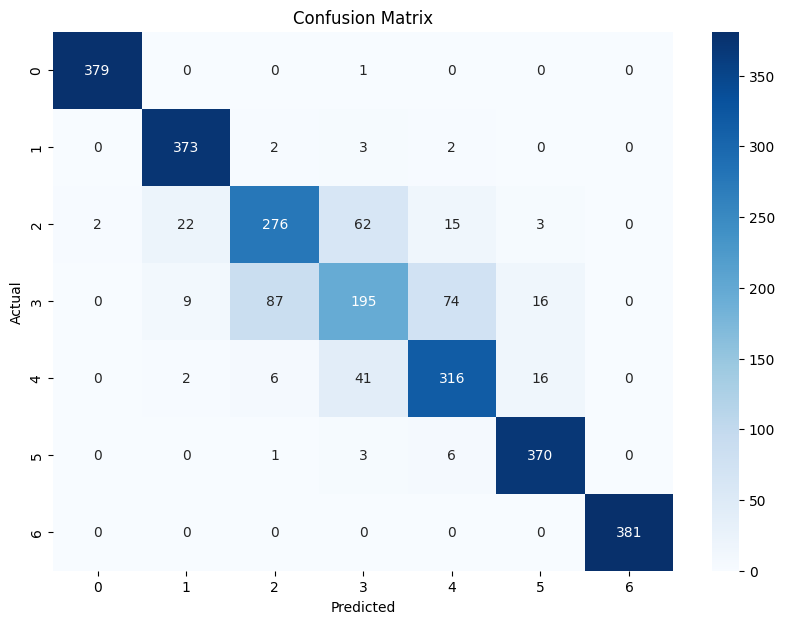

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load datasets
url_white = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
url_red = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

white_df = pd.read_csv(url_white, sep=';')
white_df['color'] = 'white'
red_df = pd.read_csv(url_red, sep=';')
red_df['color'] = 'red'

# Concatenate the datasets
df = pd.concat([red_df, white_df], ignore_index=True)

# Check for duplicates
df = df.drop_duplicates(keep='first')

# Define target and features
y = df['quality']
X = df.drop(columns=['quality', 'color'])

# Handle missing values by dropping them
X.dropna(inplace=True)

# Handle outliers (remove them)
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

X = remove_outliers(X)

# Re-define target variable y to match the filtered X
y = y.loc[X.index]

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Initialize lists to hold training and test accuracies
test_accuracies = []
n_estimators_range = range(50, 201, 10)

for n_estimators in n_estimators_range:
    classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    classifier.fit(X_train, y_train)

    # Predict on training set
    y_train_pred = classifier.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

    # Predict on test set
    y_test_pred = classifier.predict(X_test)
    test_accuracies.append(accuracy_score(y_test, y_test_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

# Train the final model with the chosen parameters
best_n_estimators = n_estimators_range[np.argmax(test_accuracies)]
rf_classifier = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42, bootstrap=True)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Best n_estimators: {best_n_estimators}')
print(f'Accuracy: {accuracy:.2f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
